In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from random import seed
from sklearn import preprocessing
seed(1)

In [9]:
class conv_lstm(nn.Module):
    def __init__(self, lr=0.001, input_channels = 1, batch_size = 1, lstm_hidden_size = 512, lstm_layer_size = 2):
        super(conv_lstm, self).__init__()
        self.lr = lr
        self.input_channels = input_channels
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.height = height
        #self.width = width
        self.batch_size = batch_size
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layer_size = lstm_layer_size
        
        self.conv_layer = nn.Conv2d(in_channels = self.input_channels, out_channels = 10,
                                   kernel_size = 3, stride = 1)
        conv_layer_init_ = 1.0/np.sqrt(self.conv_layer.weight.data.size()[0])
        self.conv_layer.weight.data.uniform_(-conv_layer_init_, conv_layer_init_)
        self.conv_layer.bias.data.uniform_(-conv_layer_init_, conv_layer_init_)
        self.conv_layer_batchNorm = nn.BatchNorm2d(10)
        self.pool = nn.AvgPool2d((2,4), stride=1)#experiment with maxpool/avgpool
        #second querry - should i maxpool/avgpool then send to lstm layer or leave it as it is? Refer to paper
        
        
        self.conv_layer1 = nn.Conv2d(in_channels = 10, out_channels = 10,
                                   kernel_size = 2, stride = 1)
        conv_layer_init_1 = 1.0/np.sqrt(self.conv_layer1.weight.data.size()[0])
        self.conv_layer1.weight.data.uniform_(-conv_layer_init_1, conv_layer_init_1)
        self.conv_layer1.bias.data.uniform_(-conv_layer_init_1, conv_layer_init_1)
        self.conv_layer_batchNorm1 = nn.BatchNorm2d(10)
        self.pool1 = nn.AvgPool2d((2,2), stride=1)#experiment with maxpool/avgpool
        
        
        
        #entirely dependant on convlayer out shape
        self.lstm_layer = nn.LSTM(input_size = 3,#check forward shape and last shape: adjust accordingly
                                 hidden_size = self.lstm_hidden_size,
                                 num_layers  = self.lstm_layer_size,
                                 batch_first = True,
                                 dropout = 0.2)
        
        self.lstm_layer1 = nn.LSTM(input_size = 512,#check forward shape and last shape: adjust accordingly
                                 hidden_size = self.lstm_hidden_size,
                                 num_layers  = self.lstm_layer_size,
                                 batch_first = True,
                                 dropout = 0.05)
        
        
        self.fc_layer = nn.Linear(self.lstm_hidden_size, self.lstm_hidden_size)#10 to represebt feature length
        fc_init_ = 1.0/np.sqrt(self.fc_layer.weight.data.size()[0])
        #initialize weights and biases
        self.fc_layer.weight.data.uniform_(-fc_init_, fc_init_)
        self.fc_layer.bias.data.uniform_(-fc_init_, fc_init_)
        
        self.fc_layer1 = nn.Linear(self.lstm_hidden_size, 10)
        fc_init_1 = 1.0/np.sqrt(self.fc_layer1.weight.data.size()[0])
        self.fc_layer1.weight.data.uniform_(-fc_init_1, fc_init_1)
        self.fc_layer1.bias.data.uniform_(-fc_init_1, fc_init_1)
        
        self.ln = nn.LayerNorm(self.lstm_hidden_size)
        
        self.to(self.device)
        
    def forward(self, frames):
        x = self.conv_layer(frames)
        x = self.conv_layer_batchNorm(x)
        x = F.relu(x)
        x = self.pool(x)
        
        
        x = self.conv_layer1(x)
        x = self.conv_layer_batchNorm1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        #print("c_Out: ",x.shape)
        x = x.squeeze()
        batch_size = x.size(0)
        
        hidden_state = torch.zeros(self.lstm_layer_size, 
                                  batch_size,
                                  self.lstm_hidden_size).to(self.device)
        cell_state = torch.zeros(self.lstm_layer_size,
                                batch_size,
                                self.lstm_hidden_size).to(self.device)
        hidden_lstm_layer = (hidden_state, cell_state)
        
        
        
        hidden_state1 = torch.zeros(self.lstm_layer_size, 
                                  batch_size,
                                  self.lstm_hidden_size).to(self.device)
        cell_state1 = torch.zeros(self.lstm_layer_size,
                                batch_size,
                                self.lstm_hidden_size).to(self.device)
        hidden_lstm_layer1 = (hidden_state1, cell_state1)
        
        #print("conv: ", x.shape)
        out, (hn,cn) = self.lstm_layer(x,(hidden_state, cell_state))
        #print("lstm: ",out.shape)
        out, (hn,cn) = self.lstm_layer1(out,(hidden_state1, cell_state1))
        
        #print("lstm_out shape: ", out.shape)
        modified_out = out[:, -1, :]
        fc_out = self.fc_layer(modified_out)
        fc_out = self.ln(fc_out)
        fc_out = F.relu(fc_out)
        fc_out = self.fc_layer1(fc_out)
        return fc_out, out, hn

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
def train_model(model, dataloader, optimizer, criterion, epochs=10):
    loss_array = []
    epoch_array = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            #print((inputs.type()))
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print((inputs.type()))
            predictions,_,__ = model(inputs)
            #print(predictions.size(), labels.squeeze().size())
            loss_ = criterion(predictions, labels.squeeze())
            loss_.backward()
            optimizer.step()
            
            running_loss += loss_.item()*inputs.size(0) 
        print(running_loss)
        loss_array.append(running_loss/len(dataloader.dataset))
        epoch_array.append(epoch)
    return loss_array, epoch_array

In [12]:
def test_model(model, data_loader, criterion, epochs = 1):
    y_true = []
    y_preds = []
    with torch.no_grad():
        for epoch in range(epochs):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    inputs = inputs.type(torch.FloatTensor)
                    labels = labels.type(torch.FloatTensor)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs,_,__ = model(inputs)
                    #print("labels: ", labels.shape)
                    #print("outputs: ", outputs.shape)
                    loss = criterion(outputs, labels.squeeze())
                                            
                    running_loss+=loss.item()*inputs.size(0)                    
                    #print("preds: ", preds, " targets: ", targets)
                    #print(y_true.shape)
                    labels = labels.squeeze()
                    y_true.append(labels.detach().cpu().numpy())
                    y_preds.append(outputs.detach().cpu().numpy())
                    
                print("epoch: ",epoch)
                print("loss: ",running_loss/len(data_loader.dataset))
    return y_true, y_preds

In [13]:
def test_model_force_feed_out(model, data_loader, criterion, epochs = 1):
    y_true = []
    y_preds = []
    switch = False
    with torch.no_grad():
        for epoch in range(epochs):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    if switch == False:
                        inputs = inputs.type(torch.FloatTensor)
                        print(inputs.size())
                        switch = True
                    else:
                        for i in range(2):
                            outputs = outputs.unsqueeze(dim = 0)
                        print("switched: ", outputs.size())
                        inputs = outputs
                        
                    labels = labels.type(torch.FloatTensor)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs,_,__ = model(inputs)
                    #print("labels: ", labels.shape)
                    #print("outputs: ", outputs.shape)
                    loss = criterion(outputs, labels.squeeze())
                                            
                    running_loss+=loss.item()*inputs.size(0)                    
                    #print("preds: ", preds, " targets: ", targets)
                    #print(y_true.shape)
                    labels = labels.squeeze()
                    y_true.append(labels.detach().cpu().numpy())
                    y_preds.append(outputs.detach().cpu().numpy())
                    
                print("epoch: ",epoch)
                print("loss: ",running_loss/len(data_loader.dataset))
    return y_true, y_preds

In [14]:
model = conv_lstm()

In [15]:
model

conv_lstm(
  (conv_layer): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer_batchNorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=(2, 4), stride=1, padding=0)
  (conv_layer1): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
  (conv_layer_batchNorm1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=1, padding=0)
  (lstm_layer): LSTM(3, 512, num_layers=2, batch_first=True, dropout=0.2)
  (lstm_layer1): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.05)
  (fc_layer): Linear(in_features=512, out_features=512, bias=True)
  (fc_layer1): Linear(in_features=512, out_features=10, bias=True)
  (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)

In [16]:
#Implement dataloader
from torch.utils.data import DataLoader

In [17]:
#how do i wanna load data?
#input: frame one
#output(label): frame 2
import ipynb.fs.full.Flood_dataloader as Flood_dataloader
import os
#file_       = 'conv_lstm.csv'
file_       = os.path.join("csv_files/", "convlstm.csv")
root_input  = 'frame_tensors/'
root_output = 'frame_output_tensors/'
dataset = Flood_dataloader.conv_lstm_dataloader(file_, root_input, root_output)
len(dataset)

78

In [18]:
split_x = 69
split_y = 9
#split_x = 191
#split_y = 5
batch_size = 1
train_set, test_set = torch.utils.data.random_split(dataset,[split_x,split_y])
train_loader = DataLoader(dataset=train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset=test_set, batch_size = batch_size, shuffle = False)

In [19]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [23]:
x_values, y_values = train_model(model, train_loader, optimizer, criterion, epochs=10)

3.7566941119730473
3.73944178968668
3.7637283615767956


KeyboardInterrupt: 

In [21]:
import seaborn as sns
import pandas as pd
data1 = {'loss':x_values,'epoch':y_values}
df1 = pd.DataFrame(data1)
df1.head()

NameError: name 'x_values' is not defined

In [22]:
plt.rcParams["figure.figsize"] = (6,3) #set plot size
plt3 = sns.lineplot(x="epoch", y="loss", data=df1) #blue

NameError: name 'df1' is not defined

In [302]:
plt3.figure.savefig("avg-pooling-10-channel.png")

In [303]:
#tr,pr = test_model(model, test_loader, criterion, epochs = 1)

In [24]:
tr,pr = test_model_force_feed_out(model, test_loader, criterion, epochs = 1) 
#in this mode, model is fed only one frame in the beginning of test data
#the model then predicts the next sequence(s) by feeding back its own outputs as inputs at the end of a prediction

torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
switched:  torch.Size([1, 1, 10, 10])
epoch:  0
loss:  0.05832563630408711


In [25]:
import sklearn.preprocessing as scaler

In [26]:
tr_np = np.array(tr)
pr_np = np.array(pr)
print(tr_np.shape, pr_np.shape)

(9, 10, 10) (9, 10, 10)


In [27]:
#convert normalized info (0 - 1) to (0 - 255)
for data in range(len(tr_np)):
    norm_ = scaler.minmax_scale(tr_np[data],feature_range=(0,255))
    tr_np[data] = norm_

In [28]:
#convert normalized info (0 - 1) to (0 - 255)
for data in range(len(pr_np)):
    norm_ = scaler.minmax_scale(pr_np[data],feature_range=(0,255))
    pr_np[data] = norm_

In [29]:
#tr_np = np.expand_dims(tr_np, axis=1) # expand dims for gif - Image sequence clip
#pr_np = np.expand_dims(pr_np, axis=1) #expand dims for gif - Image sequence clip
#print(tr_np.shape, pr_np.shape)

In [30]:
#tr_np = tr_np.transpose(0,2,3,1) #transpose in this order -Image sequence clip likes it this way
#pr_np = pr_np.transpose(0,2,3,1) #transpose in this order -Image sequence clip likes it this way
#print(tr_np.shape, pr_np.shape)

In [31]:
#from moviepy.editor import ImageSequenceClip
#clip = ImageSequenceClip(list(tr_np), fps=3)
#clip.write_gif('true_data.gif', fps=3)

In [32]:
#from moviepy.editor import ImageSequenceClip
#clip = ImageSequenceClip(list(pr_np), fps=3)
#clip.resize((200, 200))
#clip.write_gif('preicted_data.gif', fps=3)

In [33]:
#from IPython.display import display, Image
#Image('preicted_data.gif')

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

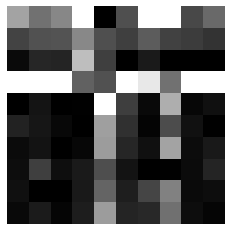

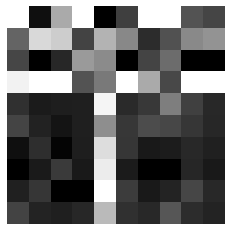

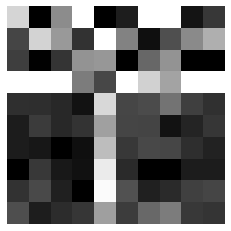

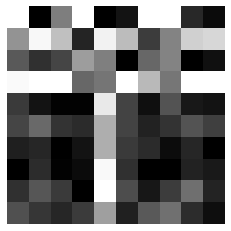

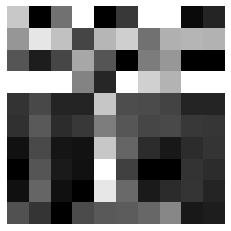

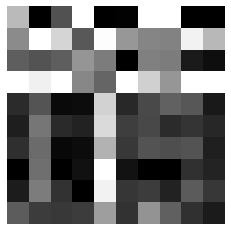

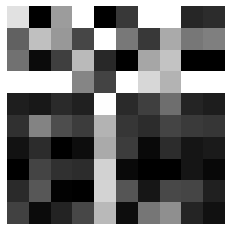

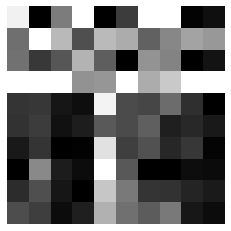

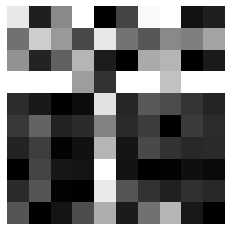

In [35]:
# Make an image file for each of the rows
filenames = []
for x in range(len(pr_np)):
    fig, ax = plt.subplots()
    ax.imshow(np.squeeze(pr_np[x]), cmap="gray")
    ax.axis("off")
    filename = 'predictions-forced/'+str(x)+".png"
    plt.savefig(filename)
    filenames.append(filename)

In [36]:
# Make the gif
filename = 'predictions-forced'
number_of_frames = 2
import imageio
with imageio.get_writer('predictions-forced/predictions-forced.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        for x in range(number_of_frames):
            writer.append_data(image)

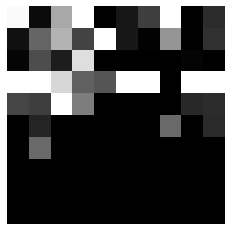

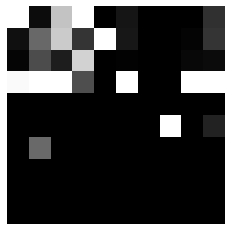

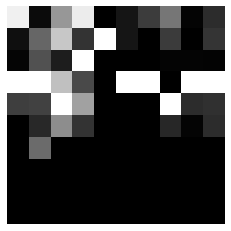

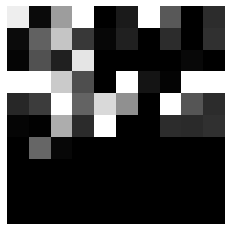

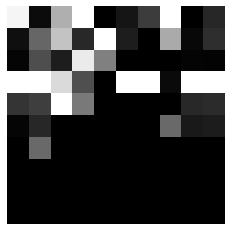

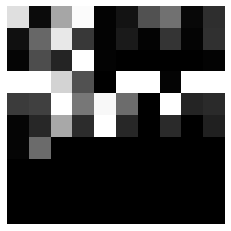

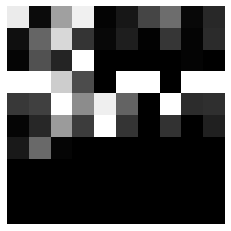

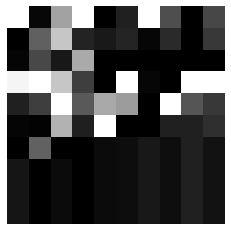

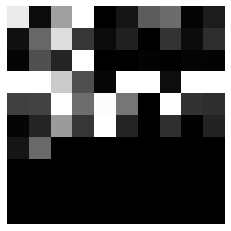

In [37]:
# Make an image file for each of the rows
filenames = []
for x in range(len(tr_np)):
    fig, ax = plt.subplots()
    ax.imshow(np.squeeze(tr_np[x]), cmap="gray")
    ax.axis("off")
    filename = 'true-predictions/'+str(x)+".png"
    plt.savefig(filename)
    filenames.append(filename)

In [38]:
# Make the gif
filename = 'true-predictions'
number_of_frames = 2
import imageio
with imageio.get_writer('true-predictions/truth.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        for x in range(number_of_frames):
            writer.append_data(image)